# Multi-frequency vs multi-coil inversion

We compare one multi-coils instrument (Explorer) and one multi-frequency instrument (GEM-2) the respective coil configurations.

| Explorer        | GEM-2           |
| --------------- | --------------- |
| HCP1.48f10000h1 | HCP1.66f425h1   |
| HCP2.82f10000h1 | HCP1.66f1525h1  |
| HCP4.49f10000h1 | HCP1.66f5325h1  |
|                 | HCP1.66f18325h1 |
|                 | HCP1.66f63025h1 |
|                 | HCP1.66f92775h1 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../../software/emagpy/src')
from emagpy import Problem

letters = ['a','b','c','d','e','f','g','h'] # for subplot naming
outputdir = '../figures/'

In [2]:
# defines coils configuration, frequency and height above the ground
coilsA = ['HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
coilsB = ['HCP1.66f1525h1', 'HCP1.66f5325h1',
       'HCP1.66f18325h1', 'HCP1.66f63025h1', 'HCP1.66f92775h1']
# HCP1.66f425h1 was excluded because in reality it's too noisy to be useful (too weak signal)
coilsList = [coilsA, coilsB]

In [3]:
def formatCoil(s):
    orientation = s[:3]
    coilspacing = s.split('f')[0][3:]
    freq = s.split('f')[1].split('h')[0]
    height = s.split('h')[1]
    return orientation + coilspacing + ' f' + freq + ' h' + height

## Sensitivity profiles
The sensitivity profile is obtained by passing a thin plate of +1 mS/m compared to background through the profile and computing this reponse for each location of the place, then normalising.

In [4]:
# sensitivity on homogeneous ground
n = 50
ecs = [15, 150]
conds = (np.ones((n, len(ecs))) * ecs).T  # npos, nlayer
depths = np.repeat(np.logspace(-1, np.log10(6), n-1)[None, :], len(ecs), axis=0)  # npos, nlayer - 1

ks = []
senss = []
for i, coils in enumerate(coilsList):
    k = Problem()
    k.setModels([depths], [conds])
    senss.append(k.computeSens(forwardModel='FSlin', coils=coils)[0])
    ks.append(k)

Forward modelling
Forward modelling


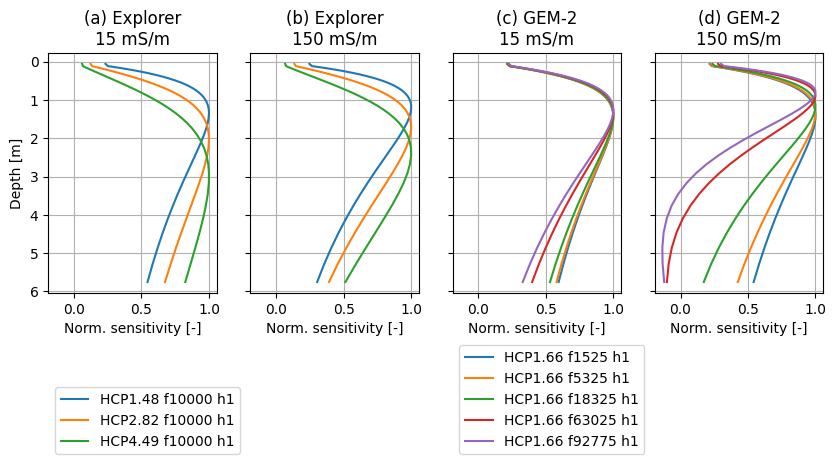

In [5]:
# sensitivity profile figure
fig, axs = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
for i, title in enumerate(['Explorer', 'GEM-2']):
    sens = senss[i][1:-1, :, :]  # remove last depth as it contains up to -inf
    sens = sens/np.max(sens, axis=0)
    depth = depths[i, 1:].copy()
    depth = np.r_[depth[0]/2, depth[:-1] + np.diff(depth)/2]
    for j, ec in enumerate(ecs):
        ax = axs[i*len(ecs) + j]
        for l in range(sens.shape[1]):
            ax.plot(sens[:, l, j], depth, '-', label=formatCoil(coilsList[i][l]))
        if j == 0:
            ncol = 1 if sens.shape[1] <= 3 else 1
            ax.legend(loc=3, bbox_to_anchor=(0, -0.7), ncol=ncol)
        ax.set_title('(' + letters[i*len(ecs)+j] + ') ' + 
                     title + '\n{:d} mS/m'.format(ec))
        ax.set_xlabel('Norm. sensitivity [-]')
axs[0].invert_yaxis()
axs[0].set_ylabel('Depth [m]')
[ax.grid(True) for ax in axs]
fig.subplots_adjust(bottom=0.4)
fig.savefig(outputdir + 'sensitivity.jpg', dpi=300)

Forward modelling
Forward modelling


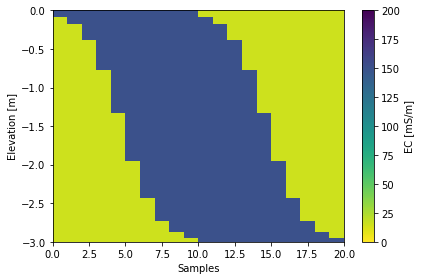

In [16]:
# foward modelling on synthetic model
nlayer = 2 # number of layers
npos = 10 # number of positions/sampling locations
conds = np.ones((npos, nlayer))*[150, 15] # EC in mS/m
x = np.linspace(0.1, 2, npos)[:, None]
depths = 0 + 3/(1+np.exp(-4*(x-1))) # depth of model

# to make a more complex model
conds = np.r_[conds, conds[:, ::-1]]
depths = np.r_[depths, depths]


ks = []
for i, coils in enumerate(coilsList):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSlin', coils=coils, noise=0.02)
    ks.append(k)
kinit = Problem() # used to plot the initial model in the figure
kinit.setModels([depths], [conds])

# initial model
fig, ax = plt.subplots()
kinit.showResults(ax=ax, vmin=0, vmax=200, maxDepth=3, dist=True)
fig.savefig(outputdir + 'true.jpg', dpi=300)

In [17]:
for k, fm in zip(ks, ['FSlin']*len(coilsList)):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[70, 70], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 200), (0, 200)], rep=5000, njobs=-1)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


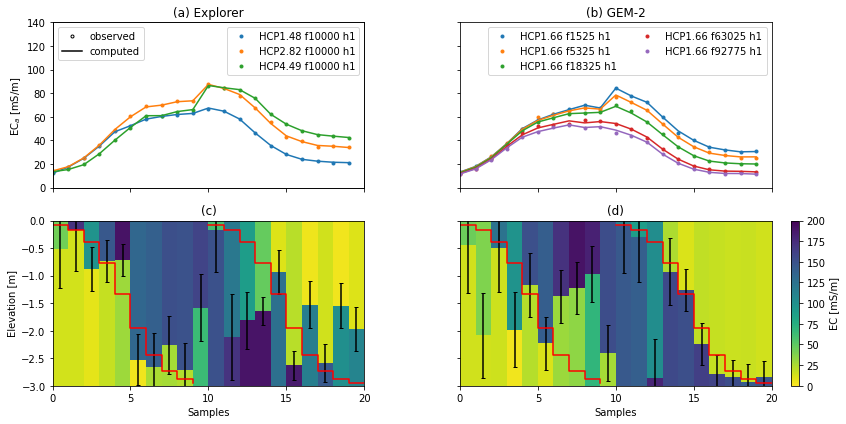

In [42]:
# figure
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey='row')

# observed and computed ECa
ax = axs[0, 0]
ks[0].showMisfit(ax=ax)
ax.set_title('(a) Explorer')
ax.set_ylabel('EC$_a$ [mS/m]')
ax.set_xlabel('')
[ax.get_lines()[i+3].set_marker('none') for i in range(3)]
[ax.get_lines()[i].set_label(formatCoil(coil)) for i, coil in enumerate(ks[0].coils)]
ax.legend()
ax2 = ax.twinx()
ax2.plot([], [], 'k.', markerfacecolor='none', label='observed')
ax2.plot([], [], 'k-', label='computed')
ax2.legend(loc=2)
ax2.set_yticks([])
ax.set_ylim([0, 140])

ax = axs[0, 1]
ks[1].showMisfit(ax=ax)
ax.set_title('(b) GEM-2')
ax.set_ylabel('')
ax.set_xlabel('')
[ax.get_lines()[i+5].set_marker('none') for i in range(5)]
[ax.get_lines()[i].set_label(formatCoil(coil)) for i, coil in enumerate(ks[1].coils)]
ax.legend(ncol=2)

# inverted EC
for i, k in enumerate(ks):
    ax = axs[1, i]
    k.showResults(ax=ax, vmin=0, vmax=200, maxDepth=3, errorbar=True, dist=False)
    ax.step(-np.vstack([depths, depths[-1,:]])[:10], 'r-', where='post') # real boundary
    ax.step(np.arange(10, 21), -np.vstack([depths, depths[-1,:]])[10:], 'r-', where='post')
    ax.set_title('(' + letters[2+i] + ')')
    if i == 0:
        fig.axes[-1].remove()
    else:
        ax.set_ylabel('')
ax.set_xticks(np.arange(0, 21, 5)) # to have int not float xticks
fig.tight_layout()

# realign the first axis
pos = axs[1, 0].get_position().bounds
pos0 = axs[0, 0].get_position().bounds
pos0 = (pos[0], pos0[1], pos[2], pos0[3])
axs[0, 0].set_position(pos0)

pos = axs[1, 1].get_position().bounds
pos0 = axs[0, 1].get_position().bounds
pos0 = (pos[0], pos0[1], pos[2], pos0[3])
axs[0, 1].set_position(pos0)

fig.savefig(outputdir + 'synthetic-inv.jpg', dpi=500)

## Effect of noise

In [8]:
noises = np.array([0, 0.01, 0.02, 0.05]*2)
n = len(noises) // 2
coilsList = [coilsA]*n + [coilsB]*n

# foward modelling
ks = []
for i, coils in enumerate(coilsList):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSlin', coils=coils, noise=noises[i])
    ks.append(k)

Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling


In [9]:
for k, fm in zip(ks, ['FSlin']*len(coilsList)):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[70, 70], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 200), (0, 200)], rep=1000, njobs=-1)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 9991.20it/s]


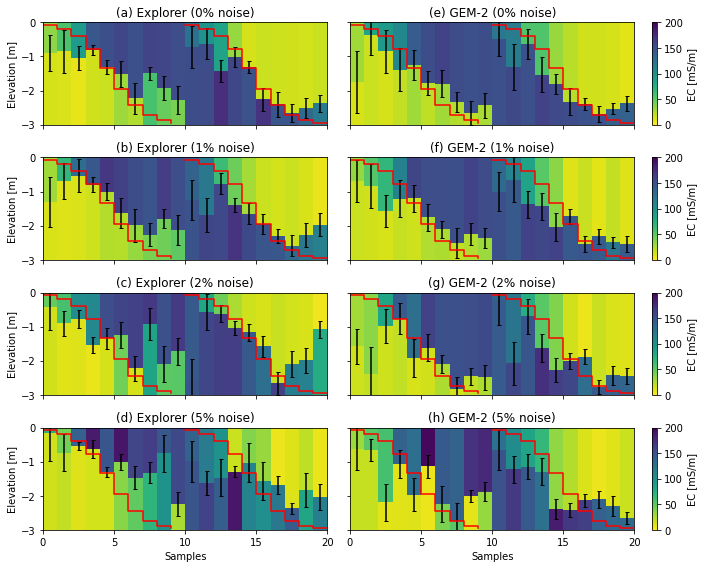

In [10]:
# figure with noise
fig, axs = plt.subplots(n, 2, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.flatten('F')
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=200, maxDepth=3, errorbar=True, dist=False)
    ax.step(-np.vstack([depths, depths[-1,:]])[:10], 'r-', where='post') # real boundary
    ax.step(np.arange(10,21), -np.vstack([depths, depths[-1,:]])[10:], 'r-', where='post')
    name = 'Explorer' if i < n else 'GEM-2'
    ax.set_title('({:s}) {:s} ({:.0f}% noise)'.format(letters[i], name, noises[i]*100))
    if i < n:
        fig.axes[-1].remove() # remove colorbar
    if i >= n:
        ax.set_ylabel('')
    if (i+1) % n != 0:
        ax.set_xlabel('')
ax.set_xticks(np.arange(0, 21, 5)) # to have int not float xticks
fig.tight_layout()
fig.savefig(outputdir + 'synthetic-noise-inv.jpg', dpi=500)

## Effect of height

In [11]:
# defines coils configuration, frequency and height above the ground
heights = [0, 0.3, 0.5, 1]*2
n = len(heights) // 2
coilsList = [coilsA]*n + [coilsB]*n

# foward modelling
ks = []
for i, coils in enumerate(coilsList):
    k = Problem()
    k.setModels([depths], [conds])
    coils = [a.replace('h1', 'h{:.1f}'.format(heights[i])) for a in coils]
    _ = k.forward(forwardModel='FSlin', coils=coils, noise=0.02)
    ks.append(k)

Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling
Forward modelling


In [12]:
for k, fm in zip(ks, ['FSlin']*len(coilsList)):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[70, 70], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 200), (0, 200)], rep=1000, njobs=-1)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 6670.86it/s]


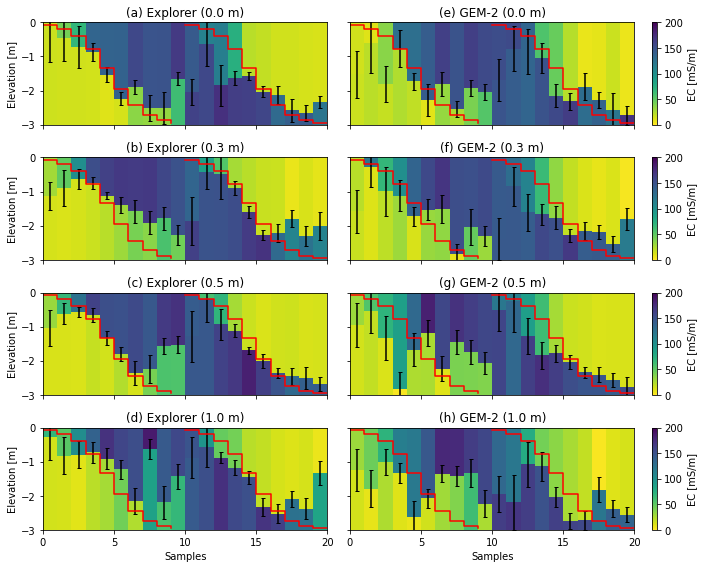

In [13]:
# figure
fig, axs = plt.subplots(n, 2, figsize=(10, 8), sharex=True, sharey=True)
axs = axs.flatten('F')
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=200, maxDepth=3, errorbar=True, dist=False)
    ax.step(-np.vstack([depths, depths[-1,:]])[:10], 'r-', where='post') # real boundary
    ax.step(np.arange(10,21), -np.vstack([depths, depths[-1,:]])[10:], 'r-', where='post')
    name = 'Explorer' if i < n else 'GEM-2'
    ax.set_title('({:s}) {:s} ({:.1f} m)'.format(letters[i], name, heights[i]))
    if i < n:
        fig.axes[-1].remove() # remove colorbar
    if i >= n:
        ax.set_ylabel('')
    if (i+1) % n != 0:
        ax.set_xlabel('')
ax.set_xticks(np.arange(0, 21, 5)) # to have int not float xticks
fig.tight_layout()
fig.savefig(outputdir + 'synthetic-height-inv.jpg', dpi=500)